# Visualizing what maximally activates the filters in a layer

see also: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

"You can think of the filters in each layer as a basis of vectors, typically overcomplete, that can be used to encode the layer's input in a compact way. The filters become more intricate as they start incorporating information from an increasingly larger spatial extent."

In [29]:
from scipy.misc import imsave, imshow
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

In [18]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

In [19]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [20]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f70b930ddd8>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f70b930dda0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f70b931c6d8>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f70b92b95f8>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f70b92cbc50>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f70b92dcf60>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f70b927e1d0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f70b928d8d0>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f70b921e550>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f70b923ffd0>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f70b924f710>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f70b91e2c18>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f70b91ffc50>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f70b920f55

In [21]:
# the name of the layer we want to visualize
layer_name = model.layers[-4].name
layer_name

'block5_conv1'

In [22]:
def tensor_to_image(x):
    
    # standardize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [23]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [24]:
# this is the placeholder for the input images
input_img = model.input

In [25]:
kept_filters = []

for filter_index in range(64):
    
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))



Processing filter 0
Current loss value: 12.454
Current loss value: 26.645
Current loss value: 43.666
Current loss value: 61.9034
Current loss value: 78.5182
Current loss value: 98.6667
Current loss value: 118.852
Current loss value: 140.252
Current loss value: 164.235
Current loss value: 187.682
Current loss value: 212.004
Current loss value: 238.218
Current loss value: 265.428
Current loss value: 291.901
Current loss value: 313.351
Current loss value: 338.604
Current loss value: 363.877
Current loss value: 391.434
Current loss value: 417.29
Current loss value: 442.344
Filter 0 processed in 10s
Processing filter 1
Current loss value: 0.0
Filter 1 processed in 0s
Processing filter 2
Current loss value: 9.62817
Current loss value: 29.446
Current loss value: 63.3724
Current loss value: 90.1475
Current loss value: 129.163
Current loss value: 155.658
Current loss value: 183.592
Current loss value: 224.271
Current loss value: 253.87
Current loss value: 290.068
Current loss value: 323.199
Cur

Current loss value: 201.675
Current loss value: 241.223
Current loss value: 276.032
Current loss value: 311.166
Current loss value: 348.483
Current loss value: 380.885
Current loss value: 413.289
Current loss value: 442.976
Current loss value: 477.655
Current loss value: 509.804
Current loss value: 538.581
Current loss value: 572.31
Current loss value: 603.295
Filter 15 processed in 10s
Processing filter 16
Current loss value: 0.0
Filter 16 processed in 0s
Processing filter 17
Current loss value: 1.31888
Current loss value: 9.71431
Current loss value: 38.2497
Current loss value: 71.0291
Current loss value: 124.019
Current loss value: 174.983
Current loss value: 233.154
Current loss value: 279.914
Current loss value: 347.299
Current loss value: 412.735
Current loss value: 483.301
Current loss value: 547.509
Current loss value: 603.874
Current loss value: 663.033
Current loss value: 724.03
Current loss value: 786.398
Current loss value: 843.504
Current loss value: 908.488
Current loss va

Current loss value: 126.068
Current loss value: 206.868
Current loss value: 275.713
Current loss value: 352.022
Current loss value: 425.54
Current loss value: 492.917
Current loss value: 553.192
Current loss value: 605.912
Current loss value: 661.25
Current loss value: 706.03
Current loss value: 750.366
Current loss value: 802.244
Current loss value: 844.184
Current loss value: 891.383
Current loss value: 947.155
Current loss value: 991.833
Current loss value: 1037.91
Filter 34 processed in 10s
Processing filter 35
Current loss value: 0.0
Filter 35 processed in 0s
Processing filter 36
Current loss value: 6.53372
Current loss value: 19.7412
Current loss value: 68.3592
Current loss value: 148.674
Current loss value: 227.04
Current loss value: 334.193
Current loss value: 425.258
Current loss value: 497.719
Current loss value: 571.58
Current loss value: 635.972
Current loss value: 693.578
Current loss value: 750.763
Current loss value: 806.399
Current loss value: 865.082
Current loss value

Current loss value: 94.2838
Current loss value: 119.274
Current loss value: 149.534
Current loss value: 175.895
Current loss value: 205.754
Current loss value: 232.382
Current loss value: 263.658
Current loss value: 288.429
Current loss value: 316.951
Current loss value: 347.381
Current loss value: 377.37
Current loss value: 409.008
Current loss value: 436.363
Filter 50 processed in 10s
Processing filter 51
Current loss value: 0.403152
Current loss value: 23.2492
Current loss value: 66.9411
Current loss value: 125.466
Current loss value: 191.908
Current loss value: 256.098
Current loss value: 320.209
Current loss value: 378.774
Current loss value: 430.116
Current loss value: 480.621
Current loss value: 529.577
Current loss value: 569.36
Current loss value: 616.398
Current loss value: 659.212
Current loss value: 700.399
Current loss value: 738.432
Current loss value: 781.553
Current loss value: 819.761
Current loss value: 857.821
Current loss value: 897.101
Filter 51 processed in 10s
Pr

Current loss value: 12.4964
Current loss value: 35.4326
Current loss value: 55.5107
Current loss value: 77.6401
Current loss value: 105.005
Current loss value: 133.306
Current loss value: 157.551
Current loss value: 186.795
Current loss value: 223.899
Current loss value: 259.877
Current loss value: 297.051
Current loss value: 342.474
Current loss value: 386.118
Current loss value: 435.159
Current loss value: 483.608
Current loss value: 536.946
Current loss value: 584.157
Current loss value: 634.833
Current loss value: 687.463
Filter 70 processed in 10s
Processing filter 71
Current loss value: 0.0
Filter 71 processed in 0s
Processing filter 72
Current loss value: 0.0492061
Current loss value: 0.258835
Current loss value: 8.01166
Current loss value: 39.1918
Current loss value: 86.0047
Current loss value: 141.931
Current loss value: 211.73
Current loss value: 281.71
Current loss value: 356.755
Current loss value: 427.449
Current loss value: 513.774
Current loss value: 597.431
Current loss

Current loss value: 0.550962
Current loss value: 5.18902
Current loss value: 35.6177
Current loss value: 103.727
Current loss value: 160.161
Current loss value: 222.85
Current loss value: 297.668
Current loss value: 376.242
Current loss value: 451.225
Current loss value: 535.423
Current loss value: 612.73
Current loss value: 687.688
Current loss value: 761.578
Current loss value: 833.708
Current loss value: 886.073
Current loss value: 959.979
Current loss value: 1020.44
Current loss value: 1080.58
Current loss value: 1137.99
Current loss value: 1195.93
Filter 88 processed in 10s
Processing filter 89
Current loss value: 0.783523
Current loss value: 1.33708
Current loss value: 2.58856
Current loss value: 6.81047
Current loss value: 16.7497
Current loss value: 34.3887
Current loss value: 49.1651
Current loss value: 67.4372
Current loss value: 92.5621
Current loss value: 130.153
Current loss value: 161.462
Current loss value: 200.546
Current loss value: 231.538
Current loss value: 265.017


Current loss value: 318.694
Current loss value: 366.078
Current loss value: 415.557
Current loss value: 460.537
Current loss value: 506.911
Current loss value: 550.775
Current loss value: 593.806
Current loss value: 639.884
Current loss value: 687.559
Current loss value: 732.205
Current loss value: 777.89
Current loss value: 823.564
Current loss value: 870.321
Filter 110 processed in 11s
Processing filter 111
Current loss value: 0.0
Filter 111 processed in 0s
Processing filter 112
Current loss value: 10.2354
Current loss value: 21.6404
Current loss value: 49.9331
Current loss value: 84.7185
Current loss value: 122.996
Current loss value: 162.514
Current loss value: 193.995
Current loss value: 223.931
Current loss value: 245.858
Current loss value: 277.058
Current loss value: 302.563
Current loss value: 327.244
Current loss value: 353.233
Current loss value: 380.605
Current loss value: 407.551
Current loss value: 437.941
Current loss value: 464.935
Current loss value: 495.31
Current los

Current loss value: 690.734
Current loss value: 752.274
Current loss value: 813.222
Current loss value: 878.439
Current loss value: 939.366
Current loss value: 1001.3
Current loss value: 1062.71
Current loss value: 1127.13
Current loss value: 1189.76
Current loss value: 1252.18
Filter 126 processed in 10s
Processing filter 127
Current loss value: 22.9448
Current loss value: 53.8594
Current loss value: 92.971
Current loss value: 138.856
Current loss value: 196.036
Current loss value: 237.83
Current loss value: 282.248
Current loss value: 318.626
Current loss value: 356.121
Current loss value: 396.461
Current loss value: 427.182
Current loss value: 458.893
Current loss value: 487.991
Current loss value: 517.634
Current loss value: 552.04
Current loss value: 579.544
Current loss value: 611.811
Current loss value: 636.787
Current loss value: 669.381
Current loss value: 696.435
Filter 127 processed in 10s
Processing filter 128
Current loss value: 11.6771
Current loss value: 34.2036
Current 

Current loss value: 647.077
Current loss value: 720.724
Current loss value: 793.875
Current loss value: 857.63
Current loss value: 929.09
Current loss value: 992.385
Current loss value: 1061.38
Current loss value: 1125.3
Current loss value: 1191.82
Current loss value: 1252.2
Current loss value: 1322.62
Filter 143 processed in 10s
Processing filter 144
Current loss value: 0.101732
Current loss value: 0.124729
Current loss value: 4.57017
Current loss value: 17.6602
Current loss value: 33.814
Current loss value: 65.5085
Current loss value: 94.5034
Current loss value: 130.632
Current loss value: 170.101
Current loss value: 204.125
Current loss value: 241.484
Current loss value: 278.672
Current loss value: 315.771
Current loss value: 348.564
Current loss value: 386.334
Current loss value: 417.925
Current loss value: 445.815
Current loss value: 483.153
Current loss value: 513.638
Current loss value: 545.654
Filter 144 processed in 10s
Processing filter 145
Current loss value: 14.5398
Current

Current loss value: 1194.8
Current loss value: 1248.99
Current loss value: 1312.45
Filter 157 processed in 10s
Processing filter 158
Current loss value: 9.1558
Current loss value: 17.1343
Current loss value: 38.2913
Current loss value: 74.8411
Current loss value: 124.382
Current loss value: 177.289
Current loss value: 239.305
Current loss value: 298.712
Current loss value: 354.891
Current loss value: 413.933
Current loss value: 468.401
Current loss value: 525.442
Current loss value: 579.366
Current loss value: 632.5
Current loss value: 684.777
Current loss value: 738.612
Current loss value: 791.54
Current loss value: 840.07
Current loss value: 886.35
Current loss value: 933.283
Filter 158 processed in 10s
Processing filter 159
Current loss value: 84.4381
Current loss value: 93.738
Current loss value: 127.663
Current loss value: 155.515
Current loss value: 176.862
Current loss value: 193.207
Current loss value: 220.611
Current loss value: 243.64
Current loss value: 268.959
Current loss 

Current loss value: 677.939
Current loss value: 727.452
Current loss value: 775.845
Current loss value: 819.199
Current loss value: 863.309
Current loss value: 909.119
Filter 175 processed in 10s
Processing filter 176
Current loss value: 0.310845
Current loss value: 17.8225
Current loss value: 74.4958
Current loss value: 151.798
Current loss value: 231.172
Current loss value: 297.957
Current loss value: 365.948
Current loss value: 434.084
Current loss value: 493.027
Current loss value: 553.107
Current loss value: 614.737
Current loss value: 672.93
Current loss value: 732.232
Current loss value: 784.814
Current loss value: 840.448
Current loss value: 896.169
Current loss value: 949.498
Current loss value: 999.57
Current loss value: 1057.49
Current loss value: 1112.81
Filter 176 processed in 11s
Processing filter 177
Current loss value: 7.60089
Current loss value: 22.0963
Current loss value: 45.7116
Current loss value: 77.2539
Current loss value: 117.645
Current loss value: 160.463
Curre

Current loss value: 482.034
Current loss value: 517.95
Current loss value: 554.124
Current loss value: 591.682
Current loss value: 624.478
Current loss value: 659.806
Filter 192 processed in 10s
Processing filter 193
Current loss value: 0.0
Filter 193 processed in 1s
Processing filter 194
Current loss value: 0.0
Filter 194 processed in 1s
Processing filter 195
Current loss value: 0.0
Filter 195 processed in 1s
Processing filter 196
Current loss value: 0.0
Filter 196 processed in 1s
Processing filter 197
Current loss value: 0.0
Filter 197 processed in 1s
Processing filter 198
Current loss value: 0.0
Filter 198 processed in 1s
Processing filter 199
Current loss value: 0.0
Filter 199 processed in 1s


In [34]:
# we will stitch the best 64 filters on a 8 x 8 grid.
n = 4

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

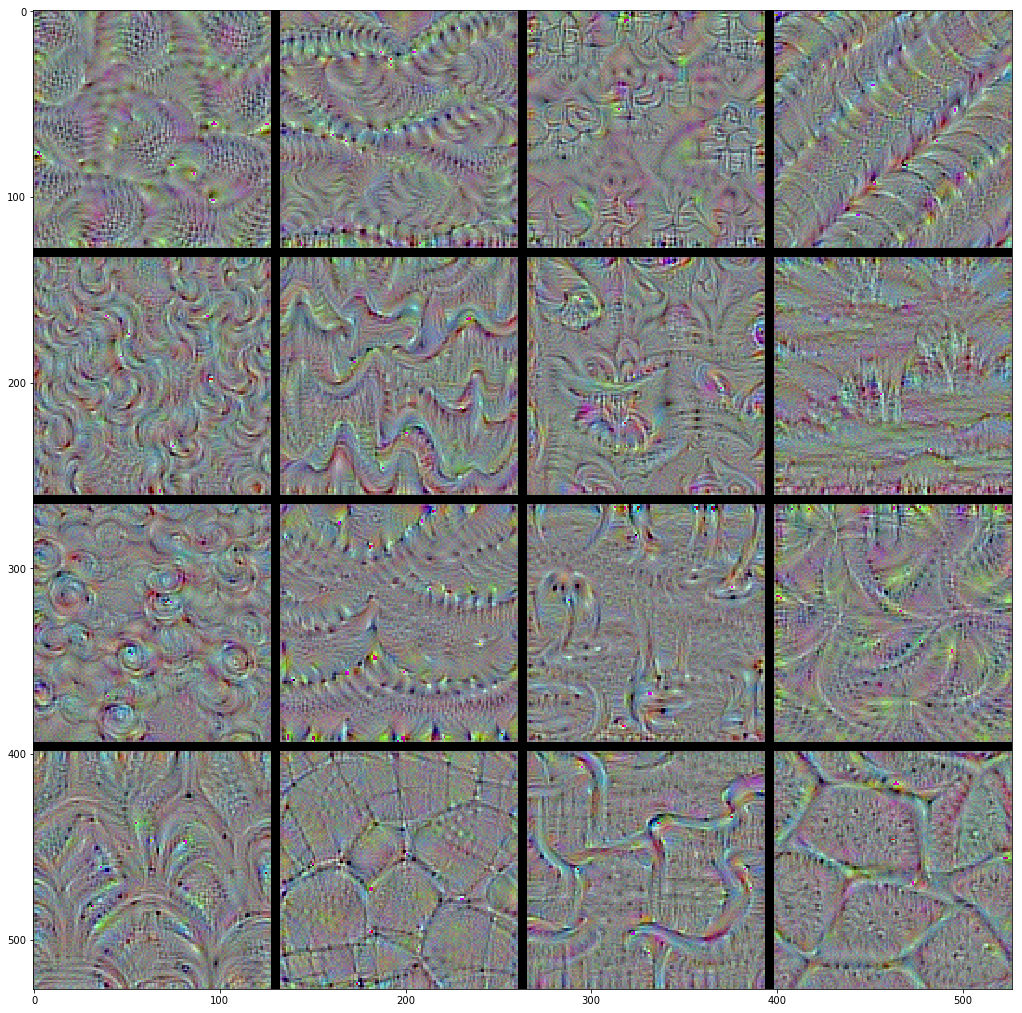

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,18)

plt.imshow(stitched_filters)

#### From the above post by F. Chollet:

Ok then. So our convnet's notion of a magpie looks nothing like a magpie --at best, the only resemblance is at the level of local textures (feathers, maybe a beak or two). Does it mean that convnets are bad tools? Of course not, they serve their purpose just fine. 
What it means is that we should refrain from our natural tendency to anthropomorphize them and believe that they "understand", say, the concept of dog, or the appearance of a magpie, just because they are able to classify these objects with high accuracy. They don't, at least not to any any extent that would make sense to us humans.

So what do they really "understand"? Two things: first, they understand a decomposition of their visual input space as a hierarchical-modular network of convolution filters, and second, they understand a probabilitistic mapping between certain combinations of these filters and a set of arbitrary labels. 
Naturally, this does not qualify as "seeing" in any human sense, and from a scientific perspective it certainly doesn't mean that we somehow solved computer vision at this point. Don't believe the hype; we are merely standing on the first step of a very tall ladder.
